In [608]:
import numpy as np
np.set_printoptions(linewidth=110)
import matplotlib.pyplot as plt
from scipy import interpolate
import SINN_functions as sf
import tensorflow as tf

In [710]:
# FEM with variable grid -> K_el calculation
# K_el = int(int(B.T @ A @ B * det(J),d_xi),d_eta)

# B precalculation
def GetB_xi_eta(r):
    # Constructs the function B(xi,eta) for a given r

    def f(xi,eta):
        N1_xi = (eta-1)/4
        N2_xi = (1-eta)/4
        N3_xi = -(1+eta)/4
        N4_xi = (1+eta)/4

        N1_eta = (xi-1)/4
        N2_eta = -(1+xi)/4
        N3_eta = (1-xi)/4
        N4_eta = (1+xi)/4

        B = np.concatenate([
            np.concatenate([N1_xi*np.eye(r), N2_xi*np.eye(r), N3_xi*np.eye(r), N4_xi*np.eye(r)], axis=1),
            np.concatenate([N1_eta*np.eye(r), N2_eta*np.eye(r), N3_eta*np.eye(r), N4_eta*np.eye(r)], axis=1)
        ], axis=0)
        return B
    return f

# Precalculate Gauss points and weights
def GetGaussPoints(n_gauss):
    xi = np.zeros((n_gauss,n_gauss))
    eta = np.zeros((n_gauss,n_gauss))
    weight = np.zeros((n_gauss,n_gauss))
    if n_gauss == 1:
        xi[0,0] = 0
        eta[0,0] = 0
        weight[0,0] = 4
    elif n_gauss == 2:
        for i in range(2):
            for j in range(2):
                xi[i,j] = -np.sqrt(1/3)*(-1)**i
                eta[i,j] = -np.sqrt(1/3)*(-1)**j
                weight[i,j] = 1
    else:
        raise ValueError(f'Gauss points not supported for n_gauss = {n_gauss}')
    return xi, eta, weight

# Precalculate B for numerical integration
def GetB(r,xi,eta):
    # r = number of latent variables
    # n_gauss = number of gauss points for numerical integration
    
    B_xi_eta = GetB_xi_eta(r)
    B = np.zeros((xi.shape[0],xi.shape[1],r*2, r*4))
    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            B[i,j,:,:] = B_xi_eta(xi[i,j],eta[i,j])
    return B

# Define general function for |J(xi,eta)| - Determinant of the Jacobian matrix
# def GetM_J_det(nodes):
#     # M_J is defined such that det(J(xi,eta)) = M_J_det @ [1, eta, xi]
#     # nodes = [[x1,y1],[x2,y2],...]
#     M_J_det = tf.concat([
#         tf.reshape(nodes[0,0]*nodes[1,1] - nodes[1,0]*nodes[0,1] + nodes[2,0]*nodes[0,1] - nodes[0,0]*nodes[2,1] + \
#          nodes[1,0]*nodes[3,1] - nodes[3,0]*nodes[1,1] + nodes[3,0]*nodes[2,1] - nodes[2,0]*nodes[3,1],(1,1)),
#         tf.reshape(nodes[1,0]*nodes[0,1] - nodes[0,0]*nodes[1,1] + nodes[0,0]*nodes[3,1] - nodes[3,0]*nodes[0,1] + \
#          nodes[2,0]*nodes[1,1] - nodes[1,0]*nodes[2,1] + nodes[3,0]*nodes[2,1] - nodes[2,0]*nodes[3,1],(1,1)),
#         tf.reshape(nodes[0,0]*nodes[2,1] - nodes[2,0]*nodes[0,1] + nodes[3,0]*nodes[0,1] - nodes[0,0]*nodes[3,1] + \
#          nodes[2,0]*nodes[1,1] - nodes[1,0]*nodes[2,1] + nodes[1,0]*nodes[3,1] - nodes[3,0]*nodes[1,1],(1,1))
#     ],axis=1)/8
#     return M_J_det

# Define general function for |J(xi,eta)| - Determinant of the Jacobian matrix
def GetM_J(xi,eta):
    # M_J is defined such that J(xi,eta) = M_J(xi,eta) @ nodes
    # nodes = [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    M_J = np.array([[eta-1,1-eta,-1-eta,1+eta],[xi-1,-1-xi,1-xi,1+xi]])/4
    return np.transpose(M_J,(2,3,0,1))


# Define general function for K_el using gaussian integrations
def GetK_el_sub(B,A,J,xi,eta,weight):
    det_J = np.linalg.det(J)[:,:,np.newaxis,np.newaxis]
    B_T = np.transpose(B,(0,1,3,2))
    K_partial = np.matmul(B_T, np.matmul(A,B)) * det_J * np.expand_dims(weight,axis=(2,3))
    K_el = np.sum(K_partial, axis=(0,1))
    return K_el

def GetK_el(A,nodes,n_gauss):
    # A = [[A11,A12],[A12,A22]]
    # nodes = [[x1,y1],[x2,y2],...]
    # n_gauss = number of gauss points for numerical integration
    
    xi,eta,weight = GetGaussPoints(n_gauss)
    r = int(A.shape[0]/2)
    B = GetB(r,xi,eta)
    J = GetM_J(xi,eta) @ nodes
    G = np.linalg.inv(J)
    B = G @ B
    K_el = GetK_el_sub(B,A,J,xi,eta,weight)
    return K_el

# A11 = np.array([[1,0],[0,1]])
# A12 = np.array([[0,0],[0,0]])
# A22 = np.array([[1,0.5],[0.5,1]])
# A = np.concatenate([
#     np.concatenate([A11,A12],axis=1),
#     np.concatenate([A12,A22],axis=1)
# ],axis=0)
# r = 2

A11 = np.array([[1]])
A12 = np.array([[0]])
A22 = np.array([[1]])
A = np.concatenate([
    np.concatenate([A11,A12],axis=1),
    np.concatenate([A12,A22],axis=1)
],axis=0)
r = 1

n_gauss = 2

xi,eta,weight = GetGaussPoints(n_gauss)
B = GetB(r,xi,eta)

# nodes = tf.constant([[-1,-1],[1,-1],[-1,1],[1,1]],tf.float32)
# nodes = tf.constant([[-0.7,-0.8],[0.7,-0.8],[-0.6,0.9],[1,1]],tf.float32)
nodes = np.array([[-0.7,-0.8],[0.7,-0.8],[-0.6,0.9],[1,1]])
J = GetM_J(xi,eta) @ nodes

# K_el0 = GetK_el_sub(B,A,J,xi,eta,weight)
K_el = GetK_el(A,nodes,2)

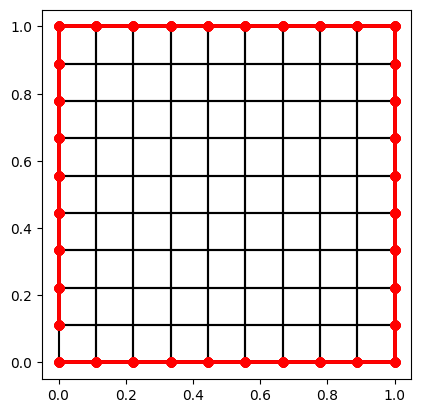

In [711]:
n_grid = 10
k = 0.

# Create nodes
nodes = np.zeros((n_grid*n_grid, 2))
for i in range(n_grid):
    for j in range(n_grid):
        x_r = i/(n_grid-1)
        y_r = j/(n_grid-1)
        x_shift = x_r + k * np.sin(2*np.pi*y_r)*x_r*(1-x_r)
        y_shift = y_r - k * np.sin(2*np.pi*x_r)*y_r*(1-y_r)
        # x_shift = x_r + k * (y_r-0.5)*x_r*(1-x_r)
        # y_shift = y_r - k * (x_r-0.5)*y_r*(1-y_r)
        nodes[i + j*n_grid,:] = np.array([x_shift, y_shift])

# Create elements
elements = np.zeros(((n_grid-1)*(n_grid-1), 4), dtype=int)
for i in range(n_grid-1):
    for j in range(n_grid-1):
        elements[i*(n_grid-1) + j,:] = np.array([i*n_grid + j, i*n_grid + j + 1, (i+1)*n_grid + j, (i+1)*n_grid + j + 1])

# Define Boundary nodes
boundary_nodes = np.zeros(4*(n_grid-1), dtype=int)
for i in range(nodes.shape[0]):
    if np.isin([0,1], nodes[i,:]).any():
        boundary_nodes[:n_grid-1] = np.arange(0,n_grid-1)
        boundary_nodes[n_grid-1:2*(n_grid-1)] = np.arange((n_grid-1), n_grid*n_grid-1, n_grid)
        boundary_nodes[2*(n_grid-1):3*(n_grid-1)] = np.arange(n_grid*n_grid-1, (n_grid-1)*n_grid,-1)
        boundary_nodes[3*(n_grid-1):4*(n_grid-1)] = np.arange((n_grid-1)*n_grid, 0, -n_grid)

internal_nodes = np.setdiff1d(np.arange(nodes.shape[0]), boundary_nodes)

# Plotting the mesh
for el in elements:
    plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    plt.plot(nodes[boundary_nodes,0], nodes[boundary_nodes,1], '-o', color='r')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


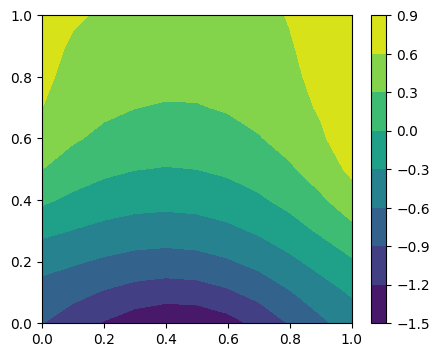

0.017984510825106076
0.005004543025295584
0.001257969761142822
0.00023726019648234023
1.3997524518151159e-05


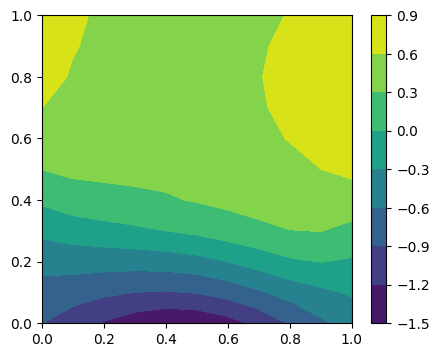

In [712]:
def SolveFEM(nodes, elements, boundary_nodes, BCfunc, internal_nodes, n_gauss, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A
    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el(A_l,nodes_el,n_gauss)
        K[Y_idx,X_idx] += K_el

    # Apply Dirichlet BC
    x_BC = nodes[boundary_nodes,0]
    y_BC = nodes[boundary_nodes,1]
    alpha = np.arctan2(y_BC-0.5,x_BC-0.5)
    l_BC = BCfunc(alpha)
    bc_idx = [[r*i+j for j in range(r)] for i in boundary_nodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internal_nodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internal_nodes,:] = l_internal
    l[boundary_nodes,:] = l_BC.reshape(-1,r)
    return l

r = 1
# A = np.concatenate([
#     np.concatenate([[[1]],[[0]]],axis=1),
#     np.concatenate([[[0]],[[1]]],axis=1)
# ],axis=0)

# A = lambda u: np.concatenate([
#     np.concatenate([[[np.exp(u.mean()/2)]],[[0]]],axis=1),
#     np.concatenate([[[0]],[[np.exp(u.mean()/2)]]],axis=1)
# ],axis=0)

A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
],axis=0)

# Define Dirichlet BC
# BCfunc = lambda alpha: np.array([(1-(-1)**i)*np.sin(alpha) + (1+(-1)**i)*np.cos(alpha) for i in range(r)]).T
n_order = 2
p = np.random.randn(2,n_order)/n_order
# BCfunc = lambda alpha: np.array([p[0]*np.cos(2*alpha) + p[1]*np.sin(2*alpha) for i in range(r)]).T
BCfunc = lambda alpha: np.array([[p[0,j]*np.cos((j+1)*alpha) + p[1,j]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)

l = SolveFEM(nodes, elements, boundary_nodes, BCfunc, internal_nodes, n_gauss, r, A, A_nl=True, l=None)

X,Y = np.meshgrid(np.linspace(0,1,11), np.linspace(0,1,11))
xi = np.array([X.flatten(), Y.flatten()]).T

l_grid = interpolate.griddata(nodes, l, xi, method='cubic')
l_grid = l_grid.reshape(11,11,r)

plt.figure(figsize=(5*r,4), dpi=100)
for i in range(r):
    plt.subplot(1,r,i+1)
    plt.contourf(X,Y,l_grid[:,:,i])
    plt.colorbar()
    # plt.scatter(nodes[:,0],nodes[:,1])

plt.show()
l_grid_l = l_grid.copy()

l_prev = l

for i in range(5):
    l = SolveFEM(nodes, elements, boundary_nodes, BCfunc, internal_nodes, n_gauss, r, A, A_nl=True, l=l_prev.copy())
    print(((l-l_prev)**2).mean())
    l_prev = l.copy()

l_grid = interpolate.griddata(nodes, l, xi, method='cubic')
l_grid = l_grid.reshape(11,11,r)
plt.figure(figsize=(5*r,4), dpi=100)
for i in range(r):
    plt.subplot(1,r,i+1)
    plt.contourf(X,Y,l_grid[:,:,i])
    plt.colorbar()
    # plt.scatter(nodes[:,0],nodes[:,1])

plt.show()

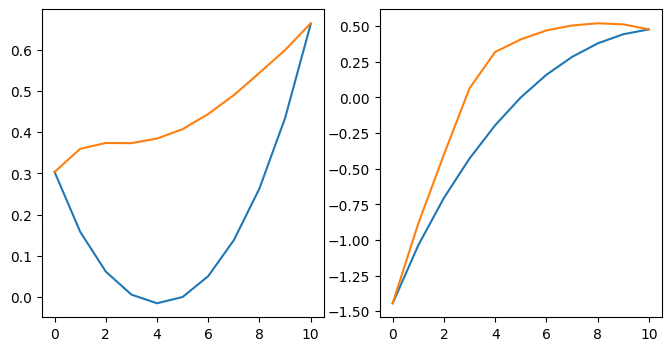

In [713]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(l_grid_l[5,:])
plt.plot(l_grid[5,:])
plt.subplot(1,2,2)
plt.plot(l_grid_l[:,5])
plt.plot(l_grid[:,5])

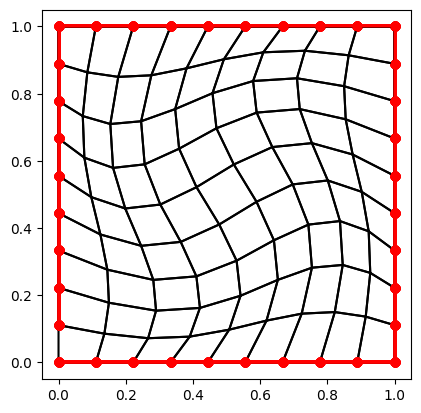

In [707]:
n_grid = 10
k = 0.4

# Create nodes
nodes = np.zeros((n_grid*n_grid, 2))
for i in range(n_grid):
    for j in range(n_grid):
        x_r = i/(n_grid-1)
        y_r = j/(n_grid-1)
        x_shift = x_r + k * np.sin(2*np.pi*y_r)*x_r*(1-x_r)
        y_shift = y_r - k * np.sin(2*np.pi*x_r)*y_r*(1-y_r)
        # x_shift = x_r + k * (y_r-0.5)*x_r*(1-x_r)
        # y_shift = y_r - k * (x_r-0.5)*y_r*(1-y_r)
        nodes[i + j*n_grid,:] = np.array([x_shift, y_shift])

# Create elements
elements = np.zeros(((n_grid-1)*(n_grid-1), 4), dtype=int)
for i in range(n_grid-1):
    for j in range(n_grid-1):
        elements[i*(n_grid-1) + j,:] = np.array([i*n_grid + j, i*n_grid + j + 1, (i+1)*n_grid + j, (i+1)*n_grid + j + 1])

# Define Boundary nodes
boundary_nodes = np.zeros(4*(n_grid-1), dtype=int)
for i in range(nodes.shape[0]):
    if np.isin([0,1], nodes[i,:]).any():
        boundary_nodes[:n_grid-1] = np.arange(0,n_grid-1)
        boundary_nodes[n_grid-1:2*(n_grid-1)] = np.arange((n_grid-1), n_grid*n_grid-1, n_grid)
        boundary_nodes[2*(n_grid-1):3*(n_grid-1)] = np.arange(n_grid*n_grid-1, (n_grid-1)*n_grid,-1)
        boundary_nodes[3*(n_grid-1):4*(n_grid-1)] = np.arange((n_grid-1)*n_grid, 0, -n_grid)

internal_nodes = np.setdiff1d(np.arange(nodes.shape[0]), boundary_nodes)

# Plotting the mesh
for el in elements:
    plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    plt.plot(nodes[boundary_nodes,0], nodes[boundary_nodes,1], '-o', color='r')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [708]:
# Assemble the global stiffness matrix
K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
K_els = np.zeros((elements.shape[0],4*r,4*r))
for i,el in enumerate(elements):
    el_idx = [[r*i+j for j in range(r)] for i in el]
    el_idx = np.concatenate(el_idx)
    # el_idx = el
    nodes_el = tf.gather(nodes, indices=el)
    X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
    K_el = GetK_el(A,nodes_el,n_gauss)
    K_els[i,:,:] = K_el
    K[Y_idx,X_idx] += K_el

# Define Dirichlet BC
# [(1-(-1)**i)*np.sin(alpha) + (1+(-1)**i)*np.cos(alpha) for i in range(r)]
# BCfunc = lambda alpha: np.array([np.sin(alpha), np.cos(alpha)]).T
BCfunc = lambda alpha: np.array([(1-(-1)**i)*np.sin(alpha) + (1+(-1)**i)*np.cos(alpha) for i in range(r)]).T
x_BC = nodes[boundary_nodes,0]
y_BC = nodes[boundary_nodes,1]
alpha = np.arctan2(y_BC-0.5,x_BC-0.5)
l_BC = BCfunc(alpha)
# l_BC = BCfunc(alpha)[:,0:1]

# # Apply Dirichlet BC
bc_idx = [[r*i+j for j in range(r)] for i in boundary_nodes]
bc_idx = np.concatenate(bc_idx)
# bc_idx = boundary_nodes
internal_idx = [[r*i+j for j in range(r)] for i in internal_nodes]
internal_idx = np.concatenate(internal_idx)
# internal_idx = internal_nodes

f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

K_BC = K[internal_idx,:][:,internal_idx]
f = f[internal_idx]

# Solve the system
l_internal = np.linalg.solve(K_BC, f)
n_CDOF = int(l_internal.shape[0]/r)
l_internal = l_internal.reshape(n_CDOF, r)

l = np.zeros((nodes.shape[0], r))
l[internal_nodes,:] = l_internal
l[boundary_nodes,:] = l_BC.reshape(-1,r)

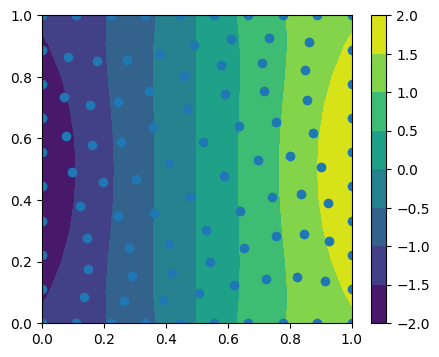

In [709]:
X,Y = np.meshgrid(np.linspace(0,1,11), np.linspace(0,1,11))
xi = np.array([X.flatten(), Y.flatten()]).T

l_grid = interpolate.griddata(nodes, l, xi, method='cubic')
l_grid = l_grid.reshape(11,11,r)

plt.figure(figsize=(5*r,4))
for i in range(r):
    plt.subplot(1,r,i+1)
    plt.contourf(X,Y,l_grid[:,:,i])
    plt.colorbar()
    plt.scatter(nodes[:,0],nodes[:,1])

plt.show()

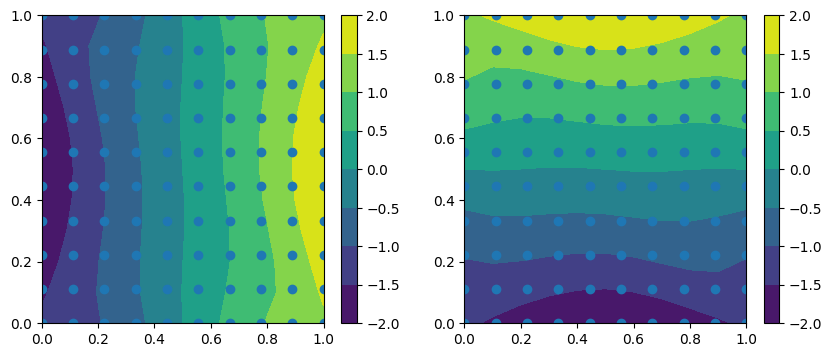

In [435]:
X,Y = np.meshgrid(np.linspace(0,1,11), np.linspace(0,1,11))
xi = np.array([X.flatten(), Y.flatten()]).T

l_grid = interpolate.griddata(nodes, l, xi, method='cubic')
l_grid = l_grid.reshape(11,11,2)

plt.figure(figsize=(5*r,4))
for i in range(r):
    plt.subplot(1,r,i+1)
    plt.contourf(X,Y,l_grid[:,:,i])
    plt.colorbar()
    plt.scatter(nodes[:,0],nodes[:,1])

plt.show()

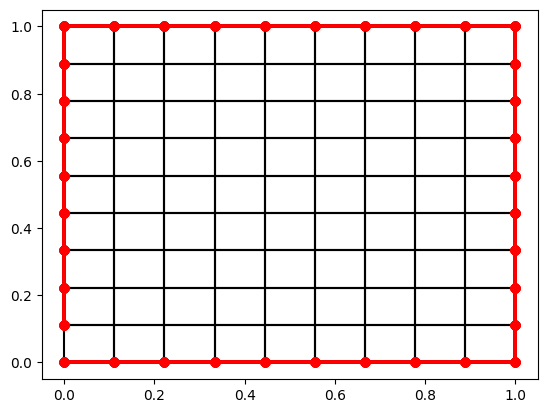

In [71]:
n_grid = 10

# Create nodes
nodes = np.zeros((n_grid*n_grid, 2))
for i in range(n_grid):
    for j in range(n_grid):
        nodes[i + j*n_grid,:] = np.array([i, j])/(n_grid-1)

# Create elements
elements = np.zeros(((n_grid-1)*(n_grid-1), 4), dtype=int)
for i in range(n_grid-1):
    for j in range(n_grid-1):
        elements[i*(n_grid-1) + j,:] = np.array([i*n_grid + j, i*n_grid + j + 1, (i+1)*n_grid + j, (i+1)*n_grid + j + 1])

# Define Boundary nodes
boundary_nodes = np.zeros(4*(n_grid-1), dtype=int)
for i in range(nodes.shape[0]):
    if np.isin([0,1], nodes[i,:]).any():
        boundary_nodes[:n_grid-1] = np.arange(0,n_grid-1)
        boundary_nodes[n_grid-1:2*(n_grid-1)] = np.arange((n_grid-1), n_grid*n_grid-1, n_grid)
        boundary_nodes[2*(n_grid-1):3*(n_grid-1)] = np.arange(n_grid*n_grid-1, (n_grid-1)*n_grid,-1)
        boundary_nodes[3*(n_grid-1):4*(n_grid-1)] = np.arange((n_grid-1)*n_grid, 0, -n_grid)

internal_nodes = np.setdiff1d(np.arange(nodes.shape[0]), boundary_nodes)

# Plotting the mesh
for el in elements:
    plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    plt.plot(nodes[boundary_nodes,0], nodes[boundary_nodes,1], '-o', color='r')


In [79]:
K_el = np.array([[  2/3,   1/3,  -1/6, -1/12,  -1/6, -1/12,  -1/3,  -1/6],
[  1/3,   2/3, -1/12,  -1/6, -1/12,  -1/6,  -1/6,  -1/3],
[ -1/6, -1/12,   2/3,   1/3,  -1/3,  -1/6,  -1/6, -1/12],
[-1/12,  -1/6,   1/3,   2/3,  -1/6,  -1/3, -1/12,  -1/6],
[ -1/6, -1/12,  -1/3,  -1/6,   2/3,   1/3,  -1/6, -1/12],
[-1/12,  -1/6,  -1/6,  -1/3,   1/3,   2/3, -1/12,  -1/6],
[ -1/3,  -1/6,  -1/6, -1/12,  -1/6, -1/12,   2/3,   1/3],
[ -1/6,  -1/3, -1/12,  -1/6, -1/12,  -1/6,   1/3,   2/3]])

r = int(K_el.shape[0]/4)

# Assemble the global stiffness matrix
K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
for el in elements:
    el_idx = [[2*i,2*i+1] for i in el]
    el_idx = np.concatenate(el_idx)
    X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
    K[Y_idx,X_idx] += K_el

# Define Dirichlet BC
BCfunc = lambda alpha: np.array([np.sin(alpha), np.cos(alpha)]).T
x_BC = nodes[boundary_nodes,0]
y_BC = nodes[boundary_nodes,1]
alpha = np.arctan2(y_BC-0.5,x_BC-0.5)
l_BC = BCfunc(alpha)

# # Apply Dirichlet BC
bc_idx = [[2*i,2*i+1] for i in boundary_nodes]
bc_idx = np.concatenate(bc_idx)
internal_idx = [[2*i,2*i+1] for i in internal_nodes]
internal_idx = np.concatenate(internal_idx)

f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

K_BC = K[internal_idx,:][:,internal_idx]
f = f[internal_idx]

# Solve the system
l_internal = np.linalg.solve(K_BC, f)
n_CDOF = int(l_internal.shape[0]/r)
l_internal = l_internal.reshape(n_CDOF, r)

l = np.zeros((nodes.shape[0], r))
l[internal_nodes,:] = l_internal
l[boundary_nodes,:] = l_BC.reshape(-1,2)

In [83]:
X,Y = np.meshgrid(np.linspace(0,1,11), np.linspace(0,1,11))
xi = np.array([X.flatten(), Y.flatten()]).T

l_grid = interpolate.griddata(nodes, l, xi, method='cubic')
l_grid = l_grid.reshape(11,11,2)

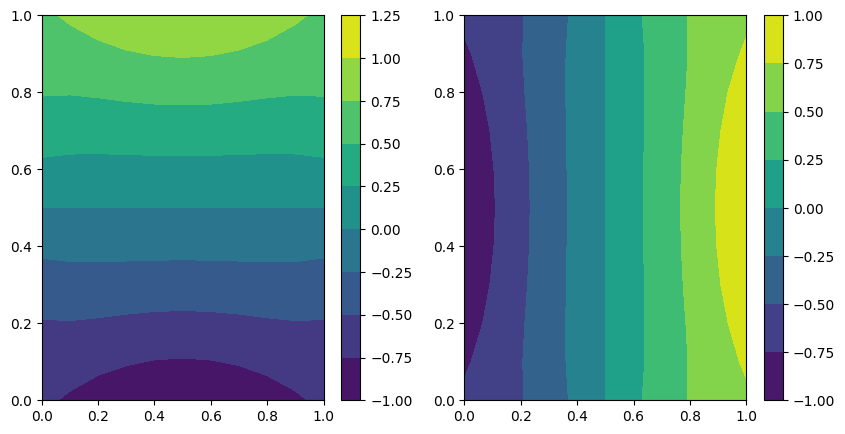

In [86]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(X,Y,l_grid[:,:,0])
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(X,Y,l_grid[:,:,1])
plt.colorbar()

In [122]:
C = np.zeros((2,2,6))
C[:,:,3] = np.array([[1,0.5],[0.5,1]])
C[:,:,4] = np.array([[1,0.5],[0.5,1]])

u_bc = np.zeros((X.shape[0],X.shape[1],2))
alpha = np.arctan2(Y-0.5,X-0.5)
u_bc[:,:,0] = np.sin(alpha)
u_bc[:,:,1] = np.cos(alpha)
u_bc[1:-1,1:-1,:] = 0
u_bc = np.moveaxis(u_bc, -1, 0)

u = sf.SolveProblem(C,u_bc,Y,X)
u = np.moveaxis(u, 0, -1)

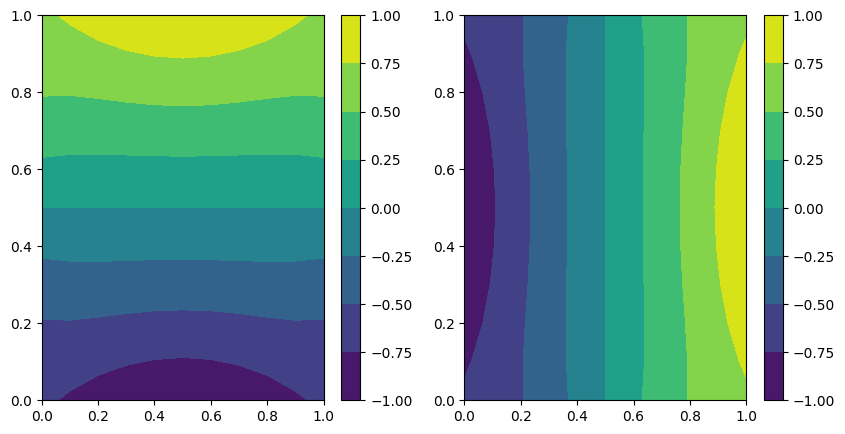

In [123]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(X,Y,u[:,:,0])
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(X,Y,u[:,:,1])
plt.colorbar()

In [270]:
# FEM with variable grid -> K_el calculation
# K_el = int(int(B.T @ A @ B * det(J),d_xi),d_eta)

# B precalculation
def GetB_xi_eta(r):
    # Constructs the function B(xi,eta) for a given r

    def f(xi,eta):
        N1_xi = (eta-1)/4
        N2_xi = (1-eta)/4
        N3_xi = -(1+eta)/4
        N4_xi = (1+eta)/4

        N1_eta = (xi-1)/4
        N2_eta = -(1+xi)/4
        N3_eta = (1-xi)/4
        N4_eta = (1+xi)/4

        B = np.concatenate([
            np.concatenate([N1_xi*np.eye(r), N2_xi*np.eye(r), N3_xi*np.eye(r), N4_xi*np.eye(r)], axis=1),
            np.concatenate([N1_eta*np.eye(r), N2_eta*np.eye(r), N3_eta*np.eye(r), N4_eta*np.eye(r)], axis=1)
        ], axis=0)
        return B
    return f

# Precalculate Gauss points and weights
def GetGaussPoints(n_gauss):
    xi = np.zeros((n_gauss,n_gauss))
    eta = np.zeros((n_gauss,n_gauss))
    weight = np.zeros((n_gauss,n_gauss))
    if n_gauss == 1:
        xi[0,0] = 0
        eta[0,0] = 0
        weight[0,0] = 4
    elif n_gauss == 2:
        for i in range(2):
            for j in range(2):
                xi[i,j] = -np.sqrt(1/3)*(-1)**i
                eta[i,j] = -np.sqrt(1/3)*(-1)**j
                weight[i,j] = 1
    else:
        raise ValueError(f'Gauss points not supported for n_gauss = {n_gauss}')
    return xi, eta, weight

# Precalculate B for numerical integration
def GetB(r,xi,eta):
    # r = number of latent variables
    # n_gauss = number of gauss points for numerical integration
    
    B_xi_eta = GetB_xi_eta(r)
    B = np.zeros((xi.shape[0],xi.shape[1],r*2, r*4))
    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            B[i,j,:,:] = B_xi_eta(xi[i,j],eta[i,j])
    return B

# Define general function for |J(xi,eta)| - Determinant of the Jacobian matrix
def GetM_J(nodes):
    # M_J is defined such that det(J(xi,eta)) = M_J @ [1, eta, xi]
    # nodes = [[x1,y1],[x2,y2],...]
    M_J = tf.concat([
        tf.reshape(nodes[0,0]*nodes[1,1] - nodes[1,0]*nodes[0,1] + nodes[2,0]*nodes[0,1] - nodes[0,0]*nodes[2,1] + \
         nodes[1,0]*nodes[3,1] - nodes[3,0]*nodes[1,1] + nodes[3,0]*nodes[2,1] - nodes[2,0]*nodes[3,1],(1,1)),
        tf.reshape(nodes[1,0]*nodes[0,1] - nodes[0,0]*nodes[1,1] + nodes[0,0]*nodes[3,1] - nodes[3,0]*nodes[0,1] + \
         nodes[2,0]*nodes[1,1] - nodes[1,0]*nodes[2,1] + nodes[3,0]*nodes[2,1] - nodes[2,0]*nodes[3,1],(1,1)),
        tf.reshape(nodes[0,0]*nodes[2,1] - nodes[2,0]*nodes[0,1] + nodes[3,0]*nodes[0,1] - nodes[0,0]*nodes[3,1] + \
         nodes[2,0]*nodes[1,1] - nodes[1,0]*nodes[2,1] + nodes[1,0]*nodes[3,1] - nodes[3,0]*nodes[1,1],(1,1))
    ],axis=1)/8
    return M_J

# Define general function for K_el using gaussian integrations
def GetK_el_sub(B,A,M_J,xi,eta,weight):
    J_gauss = np.concatenate([
        np.ones((xi.shape[0],xi.shape[1],1,1)),
        eta.reshape(xi.shape[0],xi.shape[1],1,1),
        xi.reshape(xi.shape[0],xi.shape[1],1,1)
    ],axis=2)
    K_partial = np.matmul(np.transpose(B,(0,1,3,2)) , np.matmul(A,B)) * (M_J @ J_gauss) * np.expand_dims(weight,axis=(2,3))
    K_el = np.sum(K_partial, axis=(0,1))
    return K_el

def GetK_el(A,nodes,n_gauss):
    # A = [[A11,A12],[A12,A22]]
    # nodes = [[x1,y1],[x2,y2],...]
    # n_gauss = number of gauss points for numerical integration
    
    xi,eta,weight = GetGaussPoints(n_gauss)
    r = int(A.shape[0]/2)
    B = GetB(r,xi,eta)
    M_J = GetM_J(nodes)
    K_el = GetK_el_sub(B,A,M_J,xi,eta,weight)
    return K_el

A11 = np.array([[1,0.5],[0.5,1]])
A12 = np.array([[0,0],[0,0]])
A22 = np.array([[1,0.5],[0.5,1]])
A = np.concatenate([
    np.concatenate([A11,A12],axis=1),
    np.concatenate([A12,A22],axis=1)
],axis=0)

xi,eta,weight = GetGaussPoints(2)
B = GetB(2,xi,eta)

# nodes = tf.constant([[-1,-1],[1,-1],[-1,1],[1,1]],tf.float32)
nodes = tf.constant([[-0.7,-0.8],[0.7,-0.8],[-0.6,0.9],[1,1]],tf.float32)
M_J = GetM_J(nodes)

K_el0 = GetK_el_sub(B,A,M_J,xi,eta,weight)
K_el = GetK_el(A,nodes,2)